# Mesenchymal lineage both sex - Plots

In [38]:
library(Seurat)
library(dplyr)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(gam)
library(harmony)
library(ggplot2)
library(pheatmap)
library(cowplot)
library(SoupX)
# source('G_lib_TFacts.r')

luz_colors = c('#c466b0', 
               '#779eed', '#aad3f2', '#71a2c7', '#60bddb',   '#70ccbe', 
               '#add9d3', '#7b9e99', '#91bd80', '#bdb380',  '#d4db81', '#ebd3c3',  '#dba781', 
               '#e08b8b', '#edb7b7', '#d9abb7', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb')

colors = c(luz_colors, 
           brewer.pal(n=12, name = 'Paired'), 
           brewer.pal(n=8, name = 'Set2'),
          brewer.pal(n=8, name = 'Set3'),
          brewer.pal(n=8, name = 'Accent'),
          brewer.pal(n=8, name = 'Pastel1'))

def_colors = list( reds = luz_colors[14:length(luz_colors) ],
                 yellows = c(luz_colors[7:13], brewer.pal(n=12, name = 'Paired')[8]),
                 blues = luz_colors[2:6],
                 greys = c('#e8e8e8', '#b5b5b5', '#a6a6a6') )

downsample_data = function(anndataO, var = 'annotated_clusters', N=200){
    samples = list()
    for (cl in unique(anndataO@meta.data[,var]) ){
        cells = colnames(anndataO)[ anndataO@meta.data[,var] == cl ]
        samples[[cl]] = cells
        if( length(cells) > N )
            samples[[cl]] = sample(cells, size = N, replace = F)
    }
    anndataOF = subset(anndataO, cells = unlist(samples))
    
    gene_counts = tabulate(anndataOF@assays$RNA@counts@i + 1)
    anndataOF = subset(anndataOF, features = names(gene_counts)[ gene_counts > 3 ] )
    
    return(anndataOF)
}


In [39]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] splines   stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SoupX_1.5.0        cowplot_1.1.1      pheatmap_1.0.12    ggplot2_3.3.3     
 [5] harmony_1.0        Rcpp_1.0.6         gam_1.20           foreach_1.5.1     
 [9] destiny_3.4.0      RColorBrewer_1.1-2 dplyr_1.0.4        Seurat_3.2.2      

loaded via

In [46]:
markers = list( 
                mesenchymal = c('DCN', 'PDGFRA', 'COL1A1'),
                "developmental TFs" = c('WT1', 'NR5A1'),
                gonadal = c('ARX', 'GATA4', 'LHX9', 'STAR'),
                steroidogenic = c('CYP11A1', 'CYP17A1','FDXR'),
                FetalLeydig = c('INSL3', 'HHIP', 'PTCH1', 'FDX1'),
                "T/Oi" =c('MSC',  'MMP11','KCTD8', 'SPRR2F'),
                "gonad-extragonad edge" = c('FGL2', 'PCSK2', 'ANGPTL1'),
                extragonadal = c('GATA2', 'NR2F1'),
                MullerianDuct = c('AMHR2', 'LEF1', 'TNFRSF19', 'LGR5',  'ITGBL1',  'SCUBE2'),
                mesonephros = c('MGP',  'ALX1', 'CRABP1', 'ISL1'),
                cycling = c('CDK1', 'MKI67'),
                male = c( 'RPS4Y1')       
)
unlist(markers)[ which(duplicated(unlist(markers))) ]

named character(0)

# Load processed object

In [4]:
anndataO = readRDS('/nfs/team292/lg18/with_valentina/mesenchymal.rds')

In [5]:
# anndataO$annotated_clusters[ anndataO$annotated_clusters == 'Ti_WNT5A' ] = 'M_WNT5A'

In [5]:
# # Add metadata
# meta = read.csv('figures_manual_annotation/clustering_metadata.csv', stringsAsFactors = F)
# names(meta)[1] = 'index'
# anndataO@meta.data$is_doublet = meta$is_doublet[ match(rownames(anndataO@meta.data), meta$index) ]
# anndataO@meta.data$clusters = meta$clusters[ match(rownames(anndataO@meta.data), meta$index) ]
# anndataO@meta.data$PCW = meta$PCW[ match(rownames(anndataO@meta.data), meta$index) ] %>% as.numeric(.)
# anndataO@meta.data$sex = meta$sex[ match(rownames(anndataO@meta.data), meta$index) ]
# anndataO@meta.data$sample = meta$sample[ match(rownames(anndataO@meta.data), meta$index) ]
# anndataO@meta.data$process = meta$process[ match(rownames(anndataO@meta.data), meta$index) ]
# anndataO@meta.data$individual = meta$individual[ match(rownames(anndataO@meta.data), meta$index) ]
# anndataO@meta.data$sample_source = meta$sample_source[ match(rownames(anndataO@meta.data), meta$index) ]
# anndataO@meta.data$scrublet_cluster_score = meta$scrublet_cluster_score[ match(rownames(anndataO@meta.data), meta$index) ] %>% as.numeric(.)
# write.csv(anndataO@meta.data, file = '/nfs/team292/lg18/with_valentina/mesenchymalPV_annotated.csv', quote = F, row.names = T)

# Plots supplementary

## metadata

In [7]:
levels(Idents(anndataO))

[1] "FetalLeydig"      "Ti"               "Oi"               "Gi"              
 [5] "M_MullDuct_AMHR2" "M_MullDuct_LGR5"  "M_MGP"            "M_ALX1"          
 [9] "M_prog_ISL1"      "M_cycling"

In [10]:
mycolors = c(def_colors$blues[1:2],  def_colors$reds[1], def_colors$yellows[1], def_colors$reds[3:4], def_colors$yellows[2:4],  def_colors$greys)

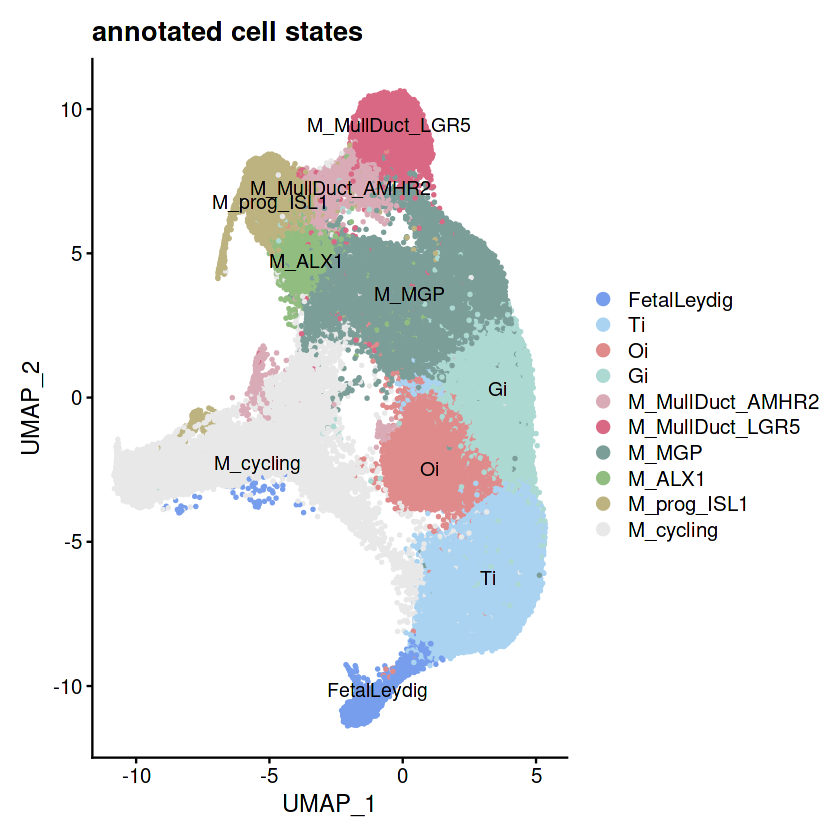

In [11]:
DimPlot(anndataO, reduction = "umap", label = T, pt.size =0.5, 
        cols = mycolors ) + 
        ggtitle('annotated cell states')
ggsave(filename = paste0('figures-stromal/0_FS3_umap_annotatedLowQC.pdf'), dpi = 300, width = 6.5, height = 5)

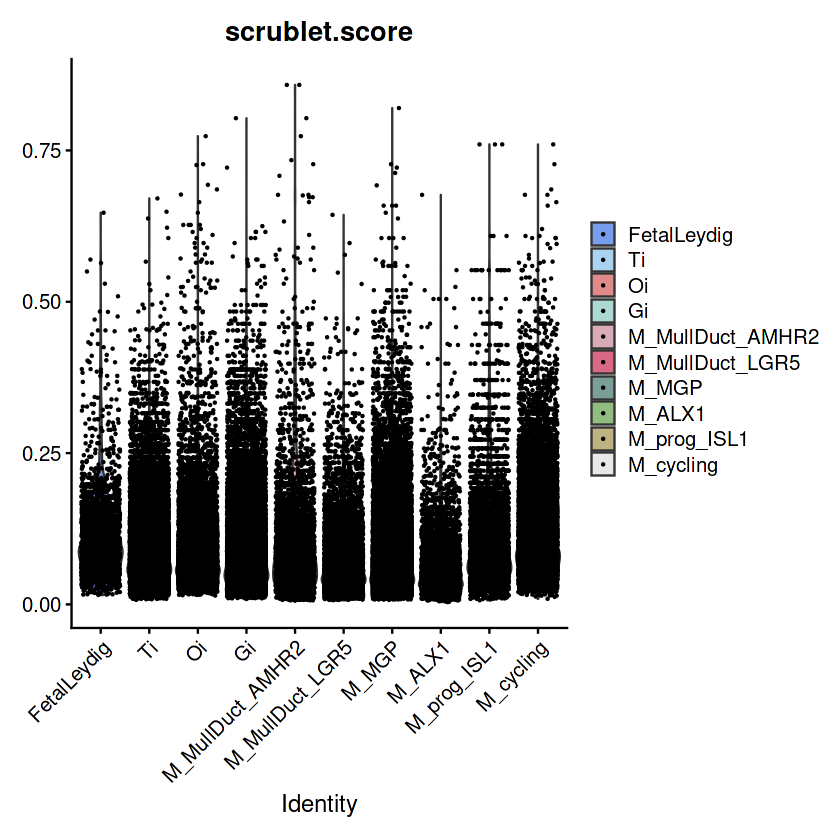

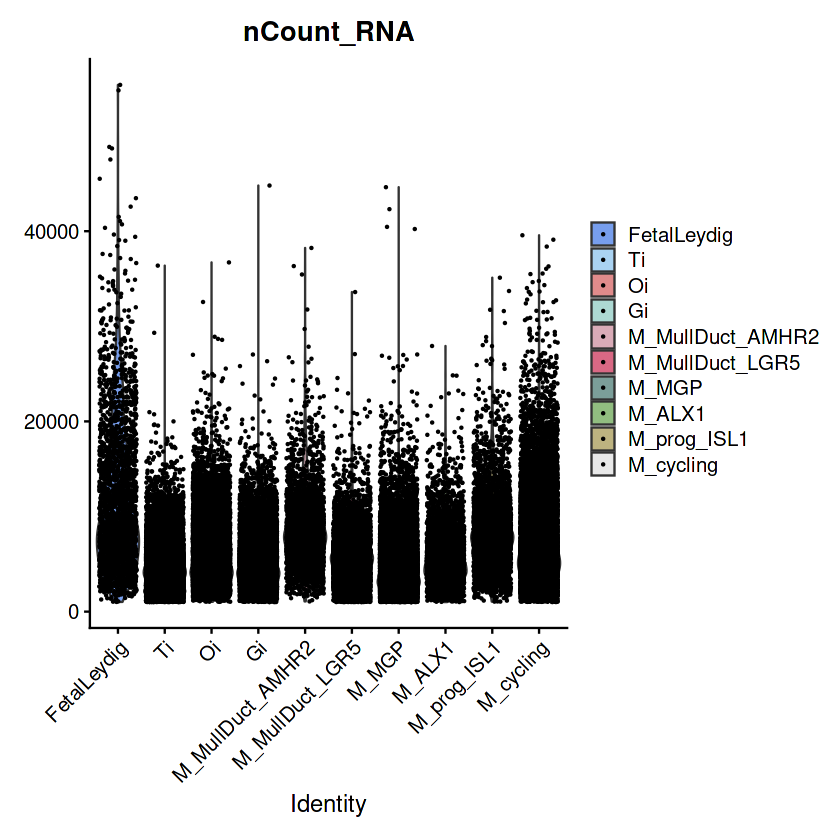

In [12]:
VlnPlot(anndataO, c('scrublet.score'), 
        pt.size = 0.2,
        ncol = 1, 
        cols = mycolors)
ggsave(filename = paste0('figures-stromal/0_FS3_boxplot_scublet.pdf'), dpi = 300, width = 6.5, height = 5)

VlnPlot(anndataO, c('nCount_RNA'), 
        pt.size = 0.2,
        ncol = 1, 
        cols = mycolors)
ggsave(filename = paste0('figures-stromal/0_FS3_boxplot_nCount_RNA.pdf'), dpi = 300, width = 6.5, height = 5)

# TF-IDF markers in high resolution populations

[1] 75324    10

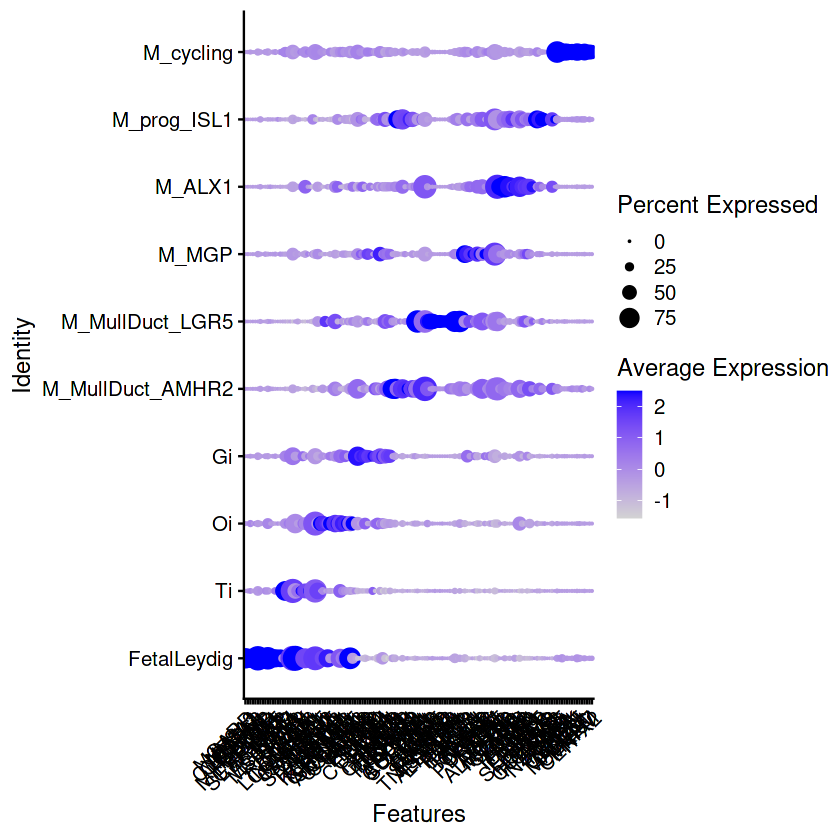

In [13]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = anndataO$annotated_clusters, N = 100000)
dim(df_tfIDF)
write.csv(df_tfIDF, file = 'figures-stromal/0_FS3_table_TFIDF_annotatedLowQC.csv', quote = F, row.names = F)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(anndataO$annotated_clusters) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'annotated_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-stromal/0_FS3_dotplot_TFIDF_annotatedLowQC.pdf'), dpi = 75, height = 5, width = 45)

# Exclude non-confident cells

In [14]:
anndataO = subset(anndataO, cells = colnames(anndataO)[ ! Idents(anndataO) %in% c('doublet', 'lowQC') ] )

## Plots

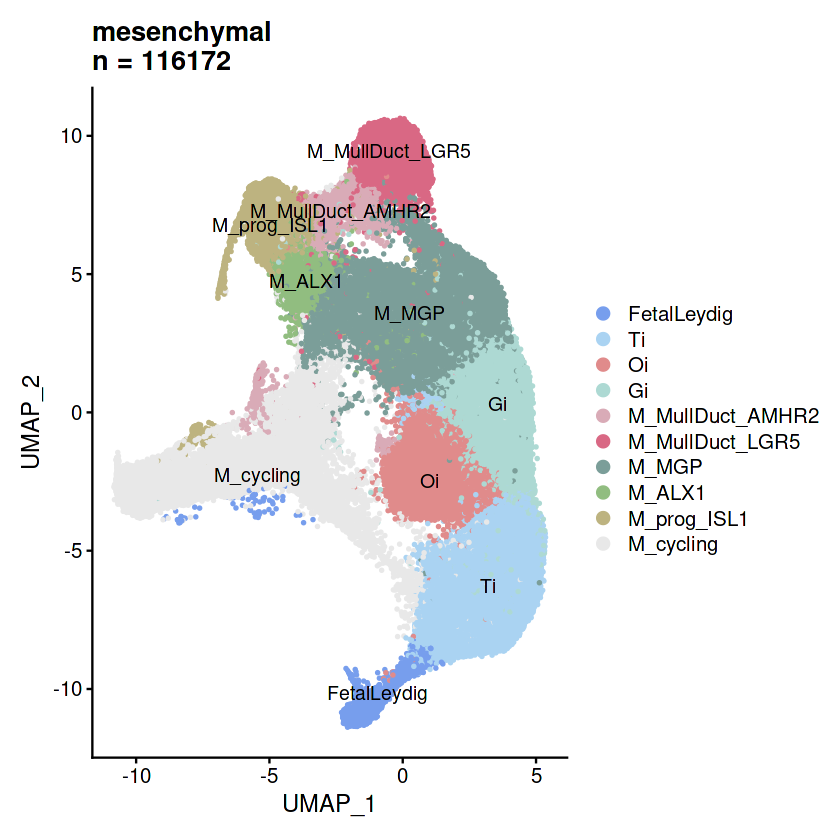

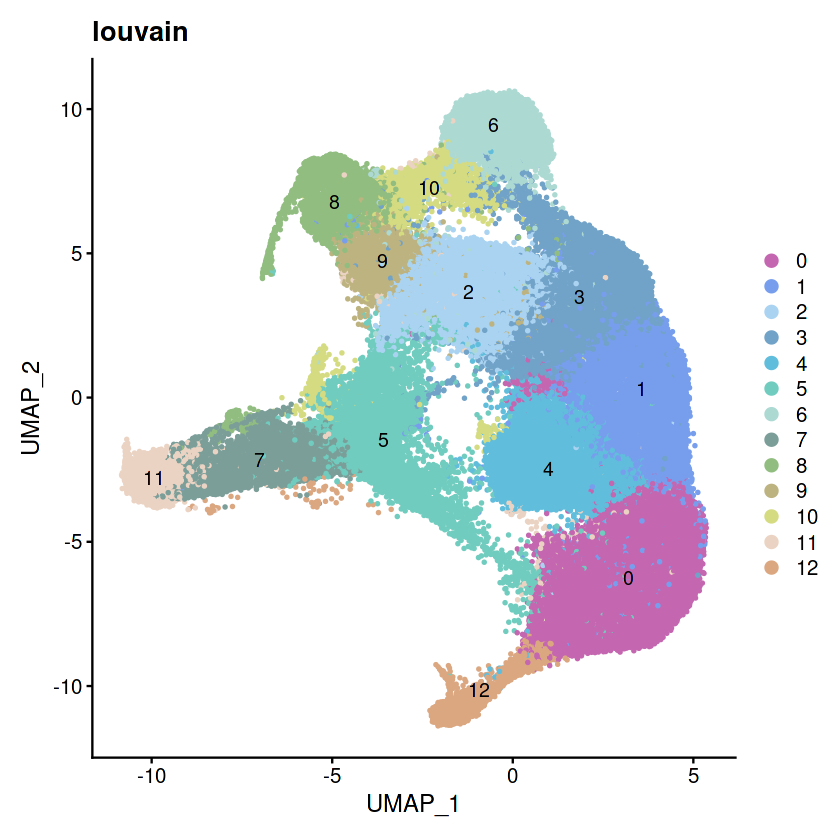

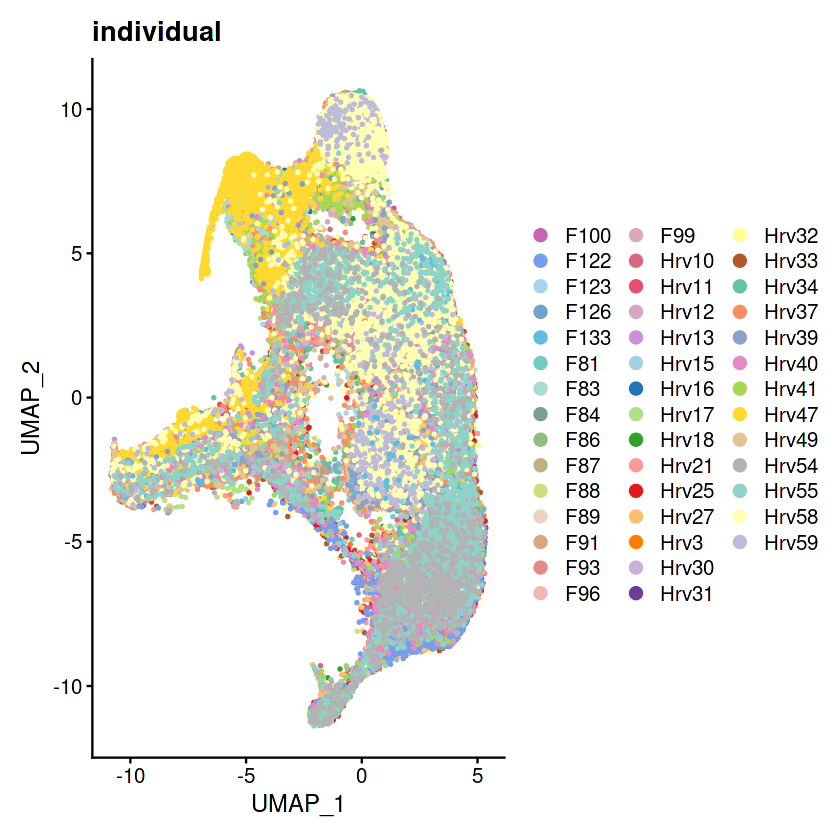

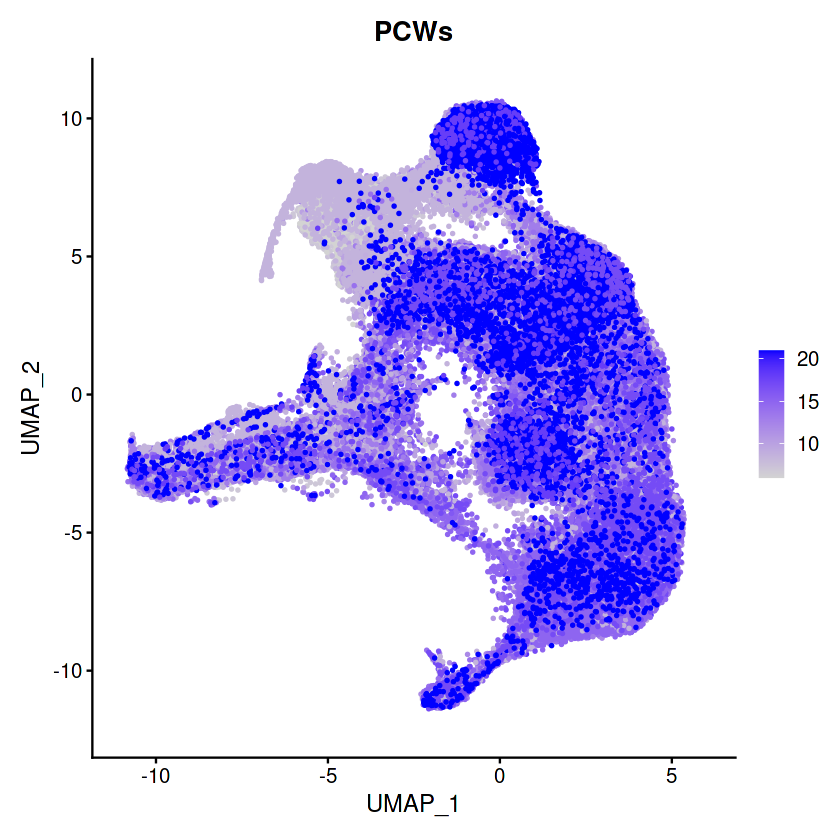

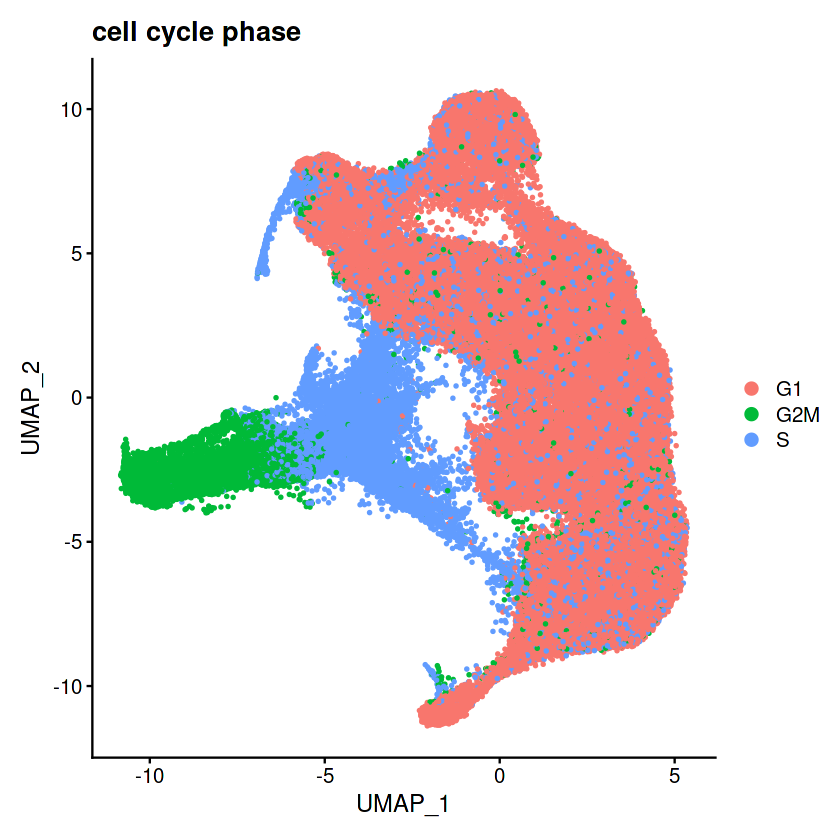

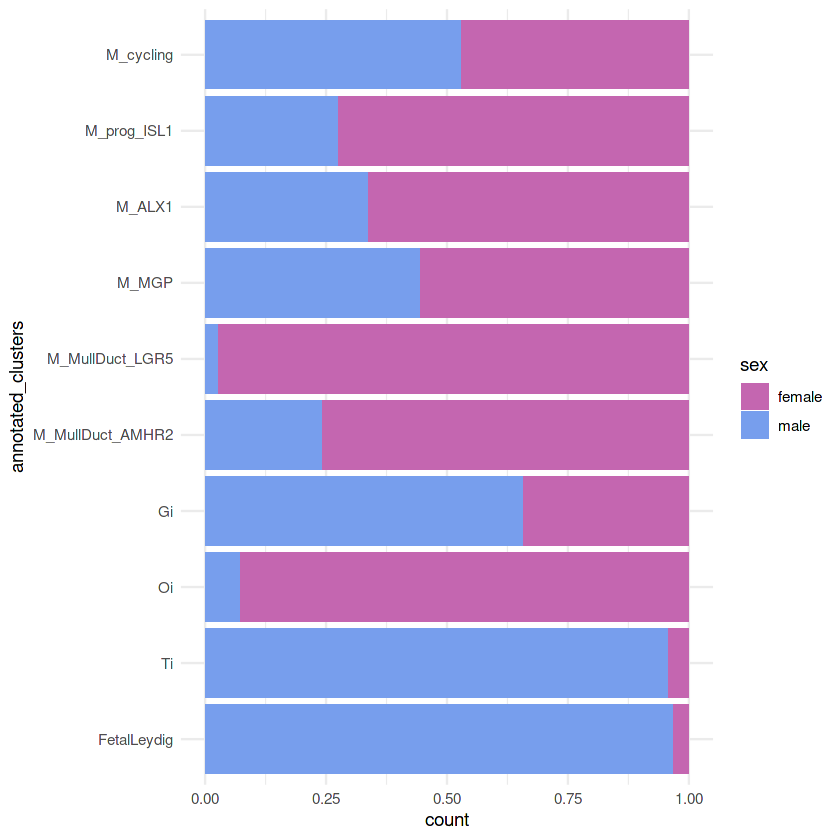

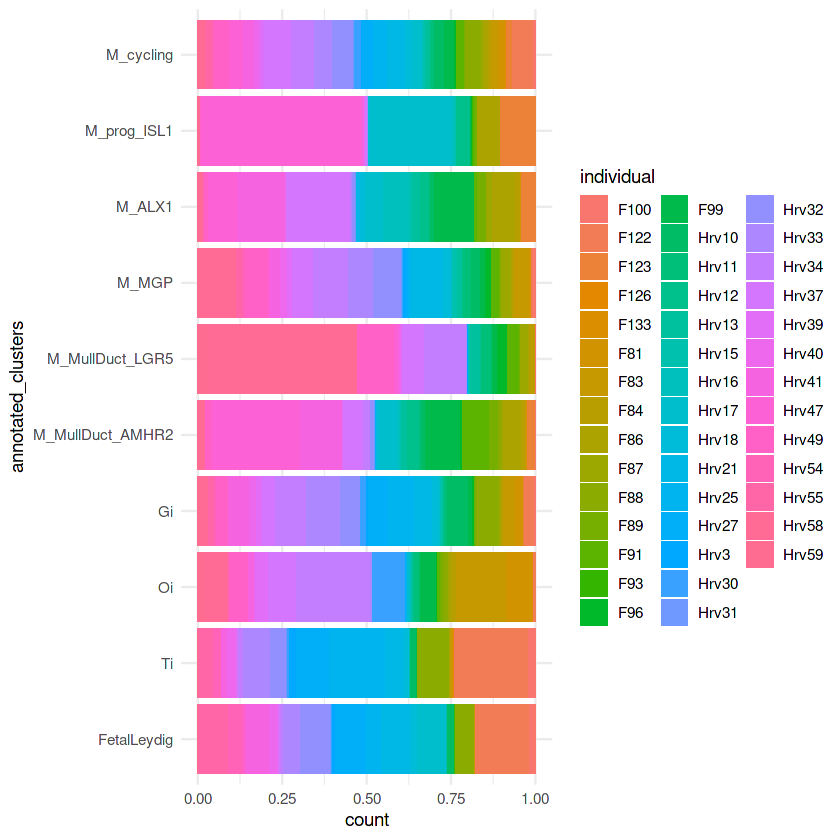

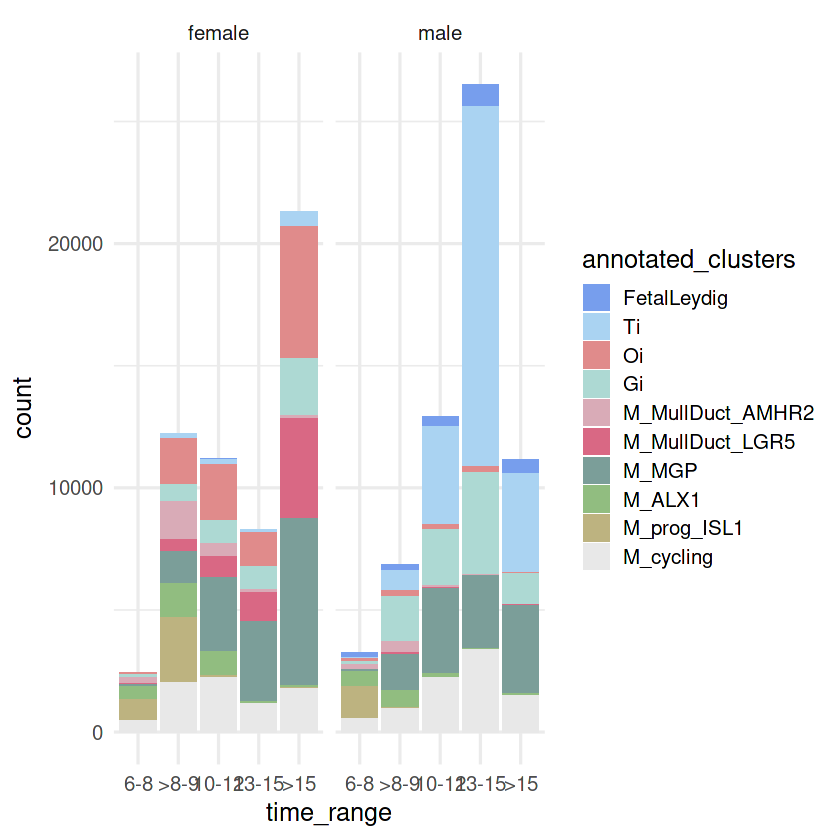

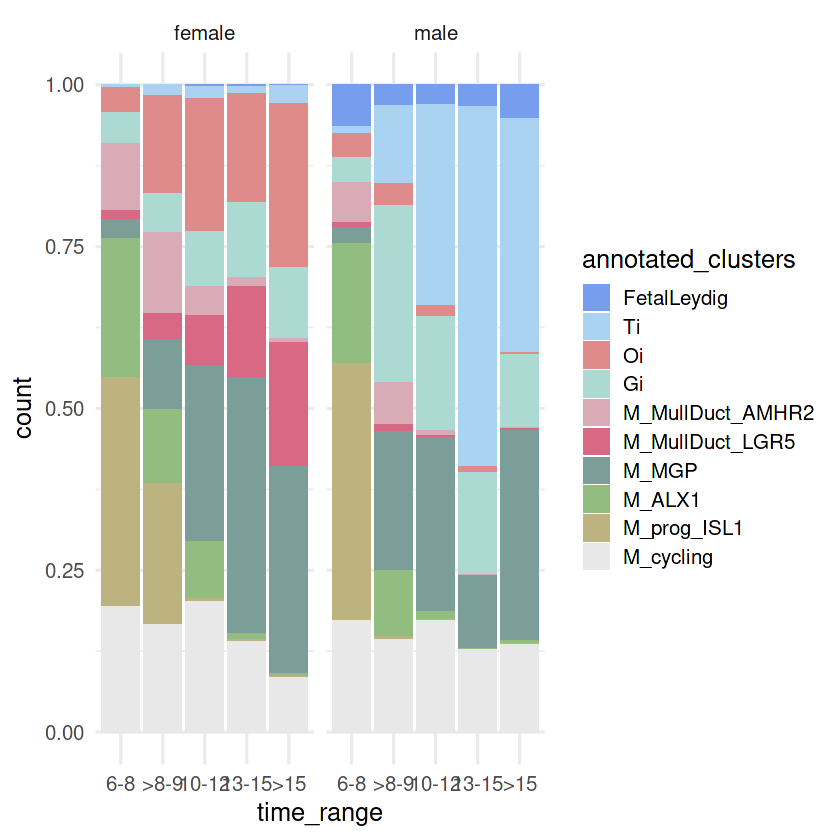

In [20]:
DimPlot(anndataO, reduction = "umap", label = T, pt.size =0.5, 
        cols = mycolors) + 
        ggtitle(paste0('mesenchymal\nn = ', ncol(anndataO)))
ggsave(filename = paste0('figures-stromal/0_F3_umap_annotated.pdf'), dpi = 300, width = 6.5, height = 5)

DimPlot(anndataO, reduction = "umap", group.by = 'seurat_clusters', label = T, cols = colors, pt.size =0.5) + ggtitle('louvain')
ggsave(filename = paste0('figures-stromal/0_FS3_umap_louvain.pdf'), dpi = 300, width = 6.5, height = 5)

DimPlot(anndataO, reduction = "umap", group.by = 'individual', label = F, cols = colors, pt.size =0.5) + ggtitle('individual')
ggsave(filename = paste0('figures-stromal/0_FS3_umap_individual.pdf'), dpi = 300, width = 6.5, height = 5)

FeaturePlot(anndataO, reduction = "umap", features = 'PCW', pt.size =0.5) + ggtitle('PCWs')
ggsave(filename = paste0('figures-stromal/0_FS3_umap_PCWs.pdf'), dpi = 300, width = 6.5, height = 5)

DimPlot(anndataO, reduction = "umap", group.by = 'Phase', pt.size =0.5) + ggtitle('cell cycle phase')
ggsave(filename = paste0('figures-stromal/0_FS3_umap_cellcyclephase.pdf'), dpi = 300, width = 6.5, height = 5)


ggplot(anndataO@meta.data, aes(x=annotated_clusters, fill = sex) ) + 
    geom_bar(position = 'fill') + coord_flip() + scale_fill_manual(values = luz_colors) +
    theme_minimal()
ggsave(filename = paste0('figures-stromal/0_FS3_barplot_sex.pdf'), dpi = 300, width = 6.5, height = 5)


ggplot(anndataO@meta.data, aes(x=annotated_clusters, fill = individual) ) + 
    geom_bar(position = 'fill') + coord_flip() + 
    theme_minimal()
ggsave(filename = paste0('figures-stromal/0_FS3_barplot_individuals.pdf'), dpi = 300, width = 6.5, height = 5)



anndataO@meta.data$time_range = '6-8'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW > 8 ] = '>8-9'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 10 ] = '10-12'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 13 ] = '13-15'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >15 ] = '>15'
anndataO@meta.data$time_range = factor(anndataO@meta.data$time_range, levels = c('6-8', '>8-9', '10-12', '13-15', '>15') )
ggplot(anndataO@meta.data, aes(x=time_range, fill = annotated_clusters) ) + 
    scale_fill_manual(values = mycolors) +
    facet_wrap(~sex)+
#     geom_bar(position = 'fill')+
    geom_bar()+
    theme_minimal(15)
ggsave(filename = paste0('figures-stromal/0_FS3_barplot_PCWs_sex.pdf'), dpi = 300, width = 9.5, height = 5)

ggplot(anndataO@meta.data, aes(x=time_range, fill = annotated_clusters) ) + 
    scale_fill_manual(values = mycolors) +
    facet_wrap(~sex)+
    geom_bar(position = 'fill')+
    theme_minimal(15)
ggsave(filename = paste0('figures-stromal/0_FS3_barplot_PCWs_sexII.pdf'), dpi = 300, width = 9.5, height = 5)

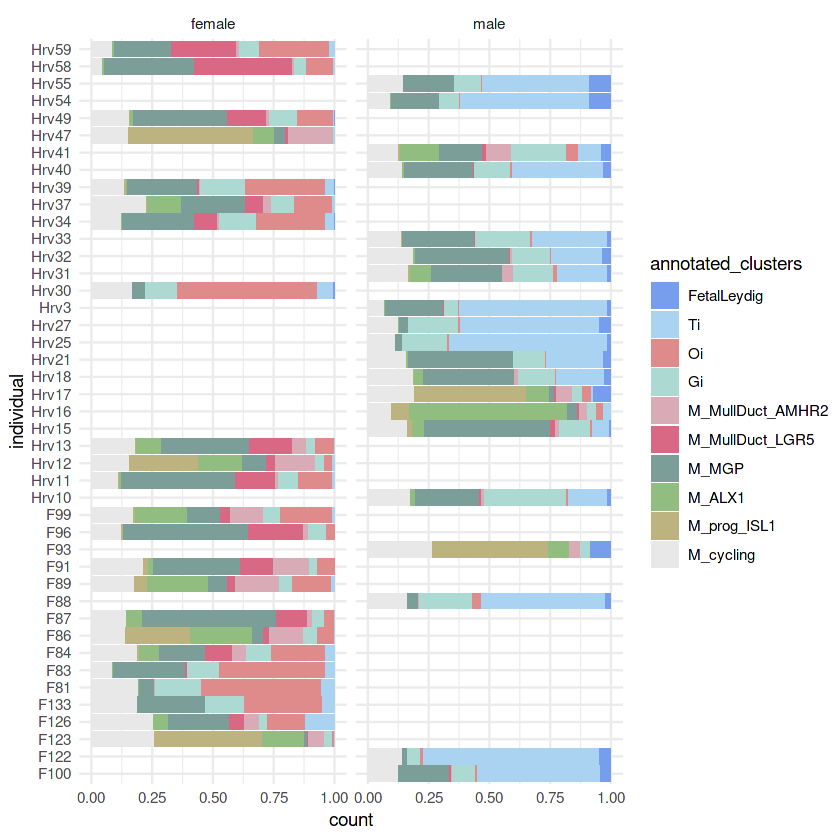

In [16]:
ggplot(anndataO@meta.data, aes(x=individual, fill = annotated_clusters) ) + 
    geom_bar(position = 'fill') + coord_flip() + scale_fill_manual(values = mycolors) +
    facet_wrap(~sex)+
    theme_minimal()
ggsave(filename = paste0('figures-stromal/0_FS3_barplot_individuals.pdf'), dpi = 300, width = 6.5, height = 5)

# Known markers

In [ ]:
col_dot = c('grey90',  brewer.pal(n = 9, name = 'Reds')[7])
DotPlot(anndataO, features = markers, cols = col_dot) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-stromal/0_F3_dotplot_markers.pdf'), dpi = 75, height = 5, width = 15)

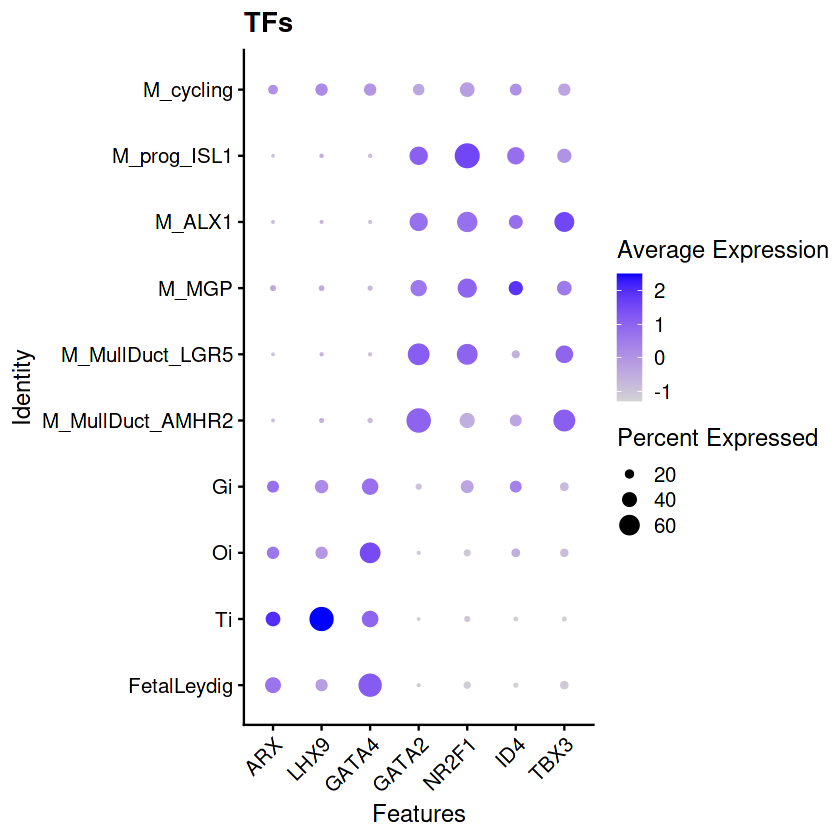

In [18]:
DotPlot(anndataO, features = c('ARX', 'LHX9', 'GATA4', 'GATA2',  'NR2F1', 'ID4', 'TBX3')) + RotatedAxis() + ggtitle('TFs')

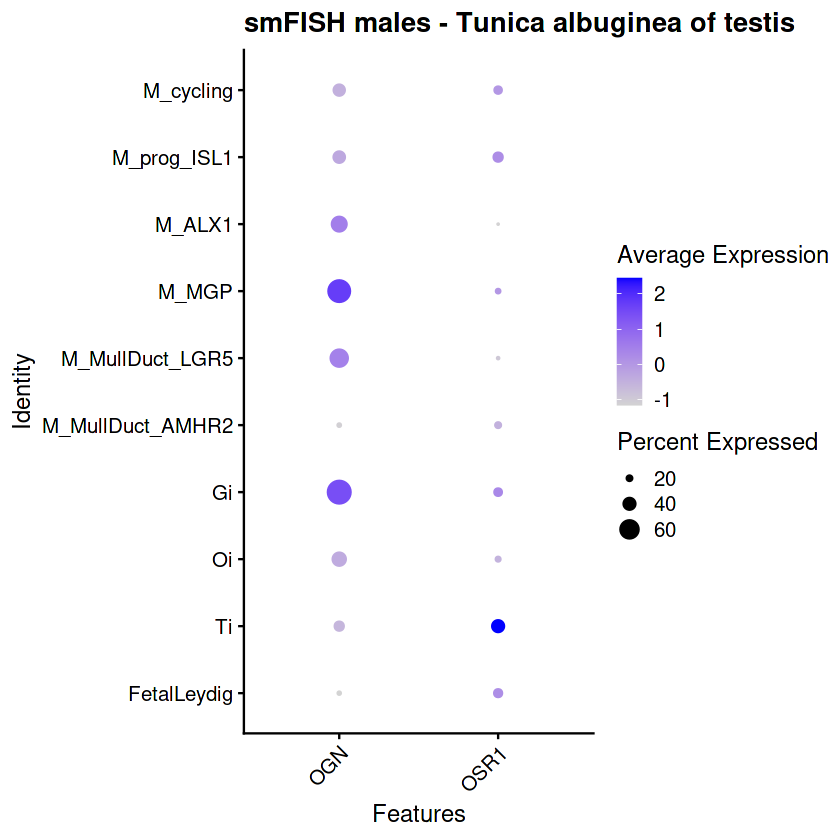

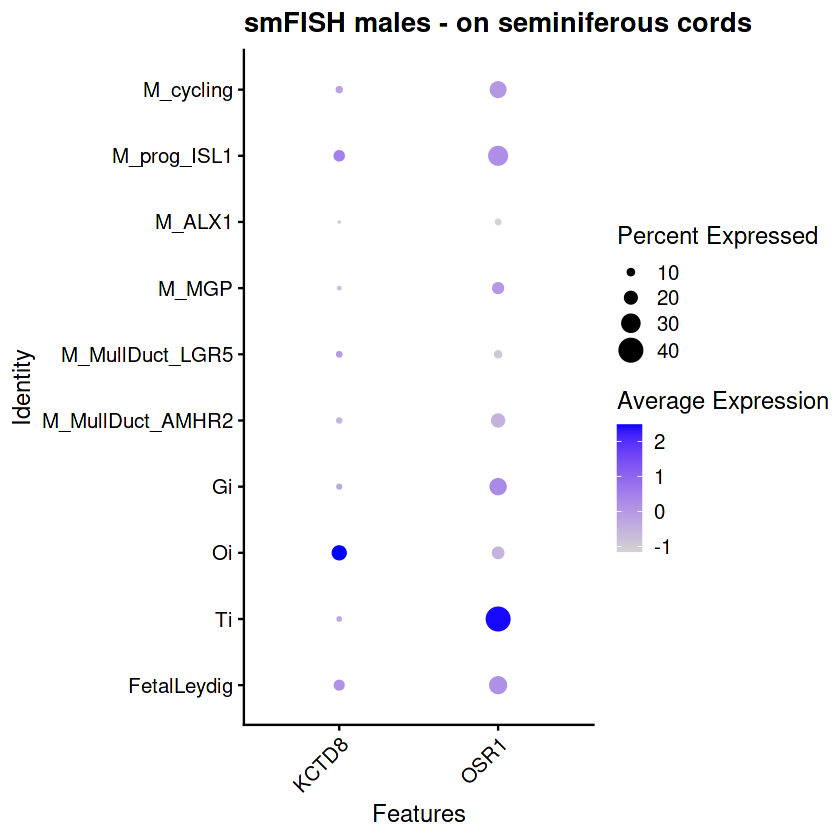

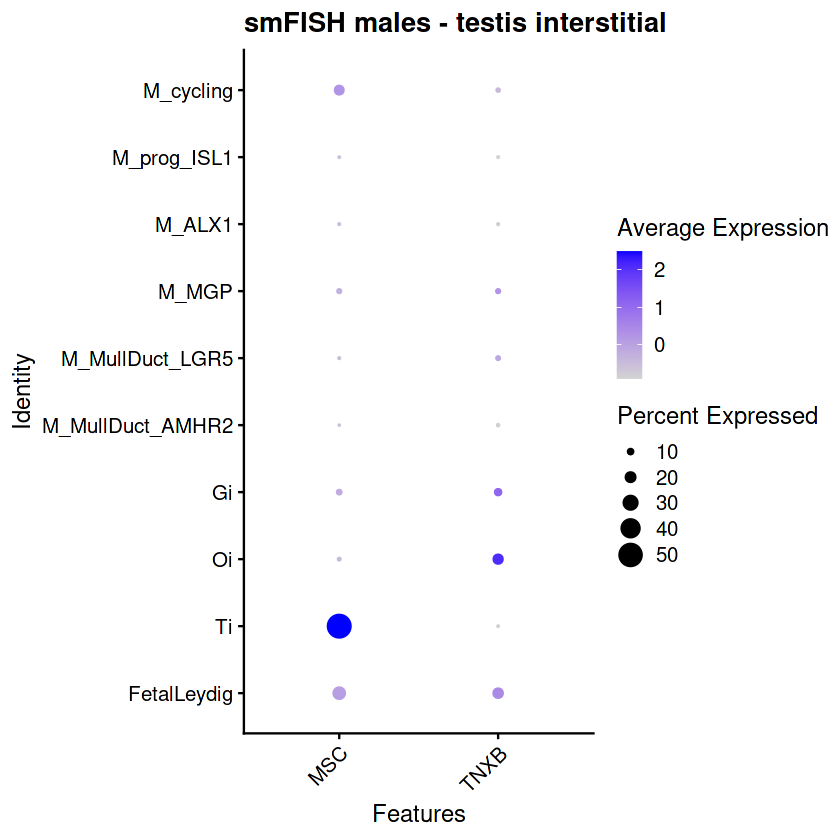

In [19]:
DotPlot(anndataO, features = c('OGN', 'OSR1')) + RotatedAxis() + ggtitle('smFISH males - Tunica albuginea of testis')
DotPlot(anndataO, features = c('KCTD8', 'OSR1')) + RotatedAxis() + ggtitle('smFISH males - on seminiferous cords')
DotPlot(anndataO, features = c('MSC', 'TNXB')) + RotatedAxis() + ggtitle('smFISH males - testis interstitial')

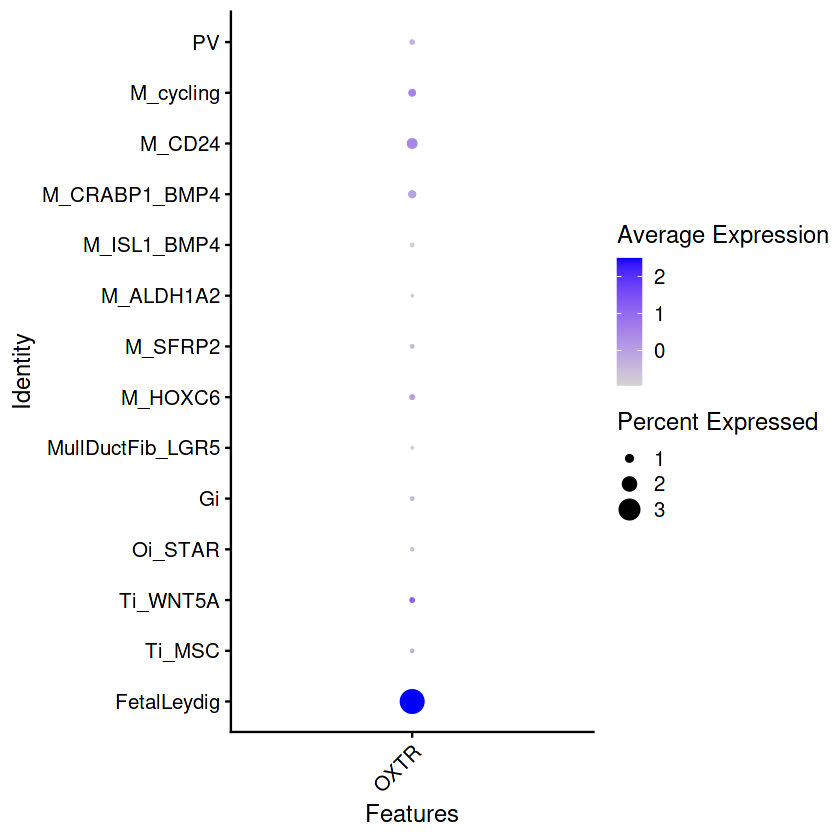

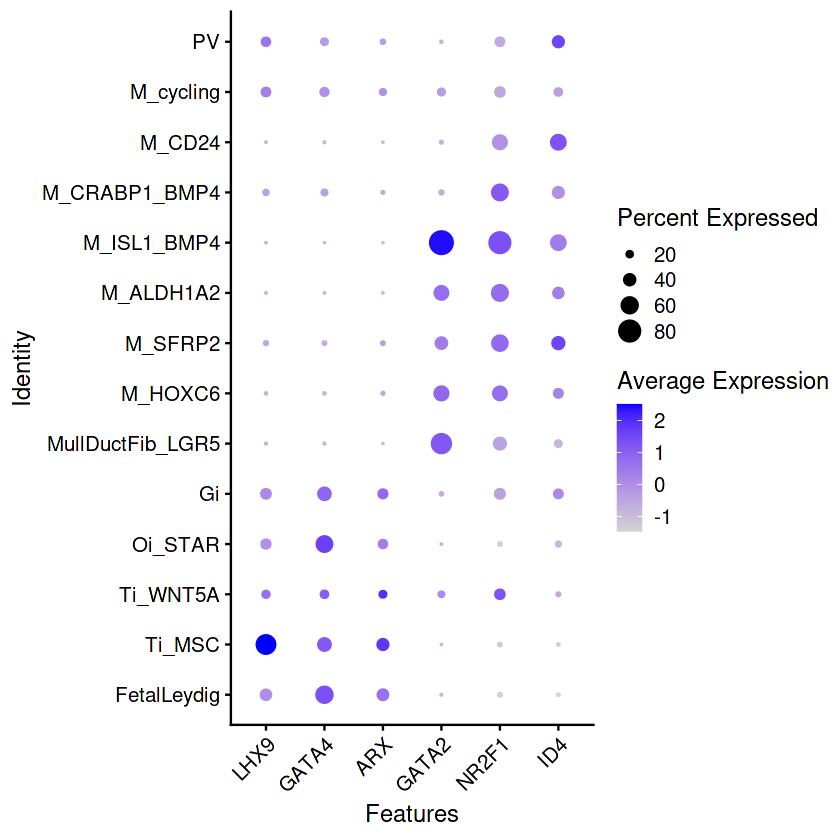

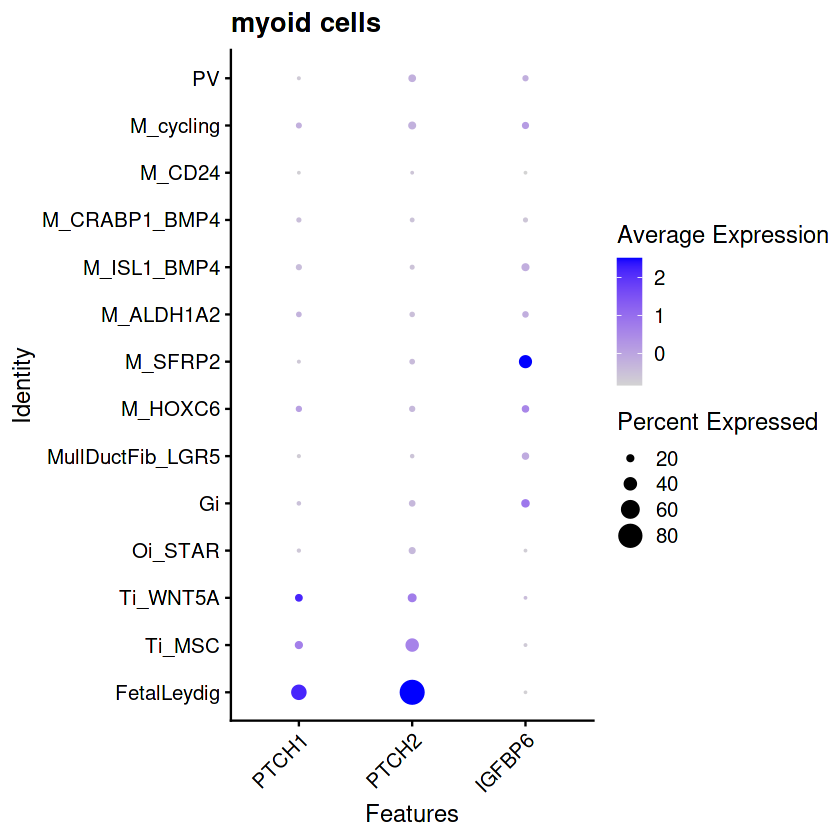

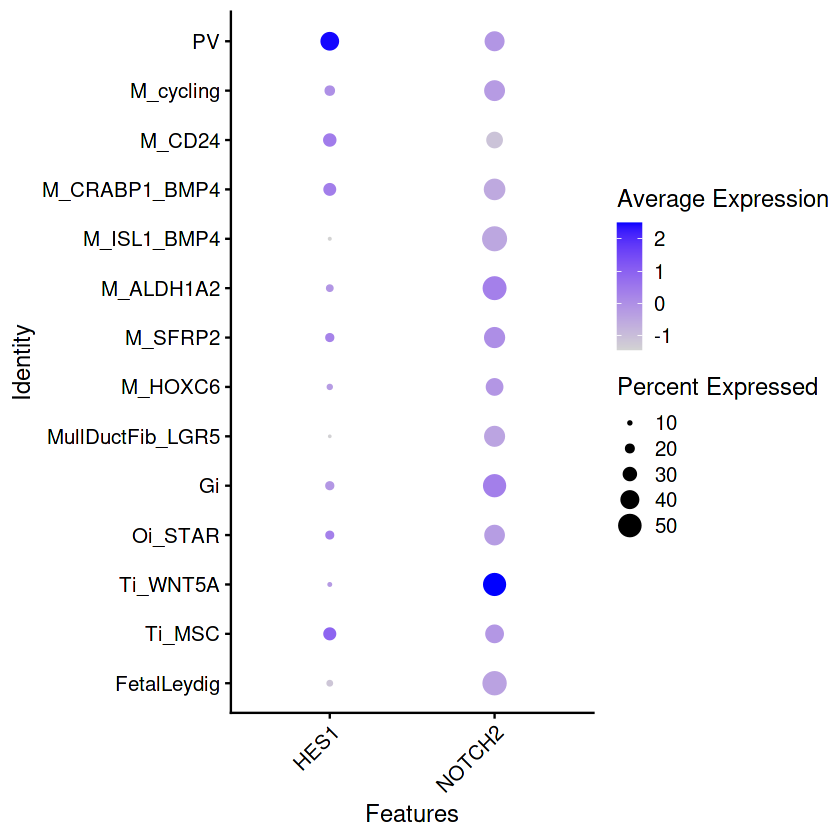

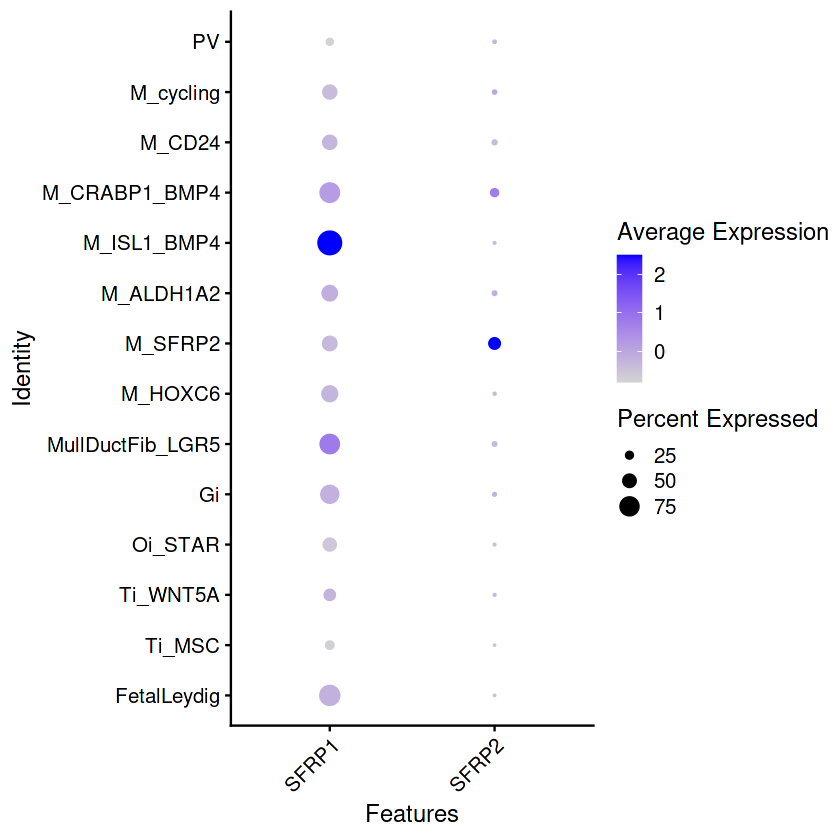

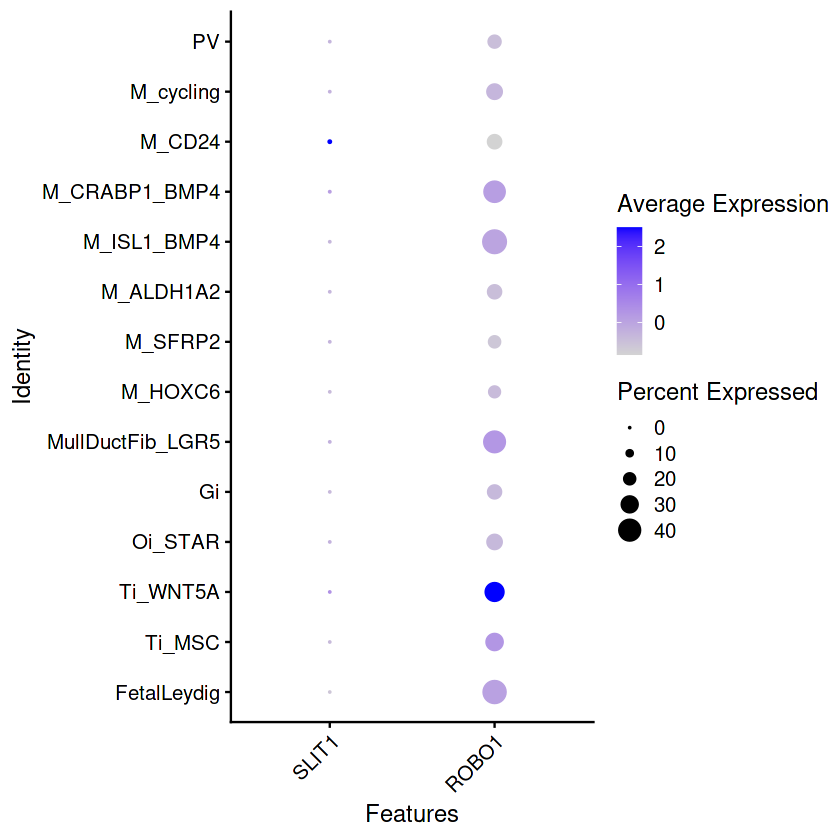

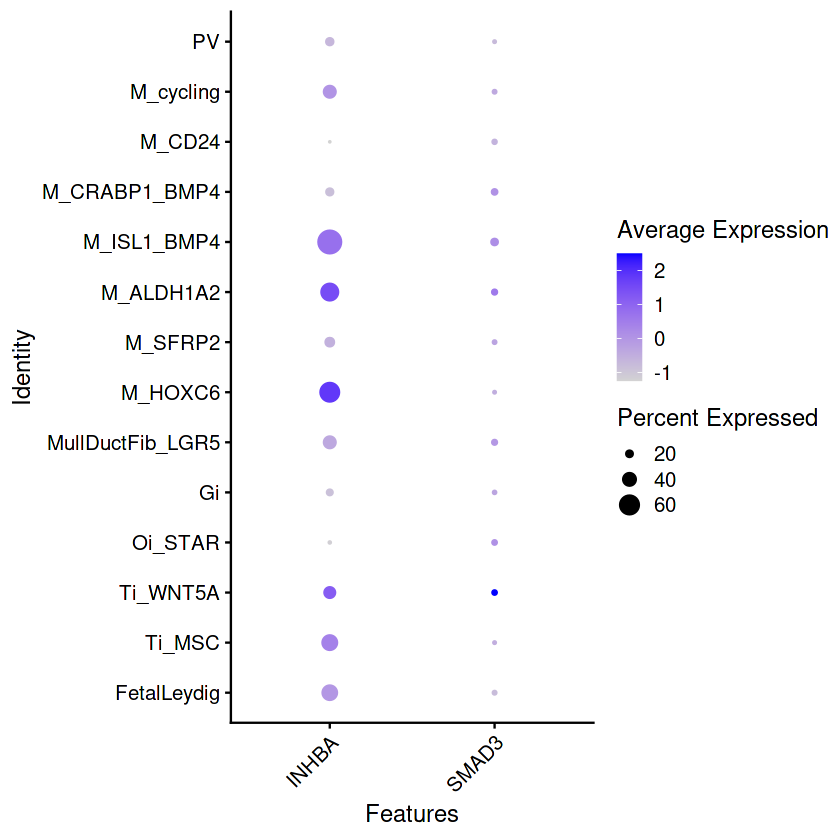

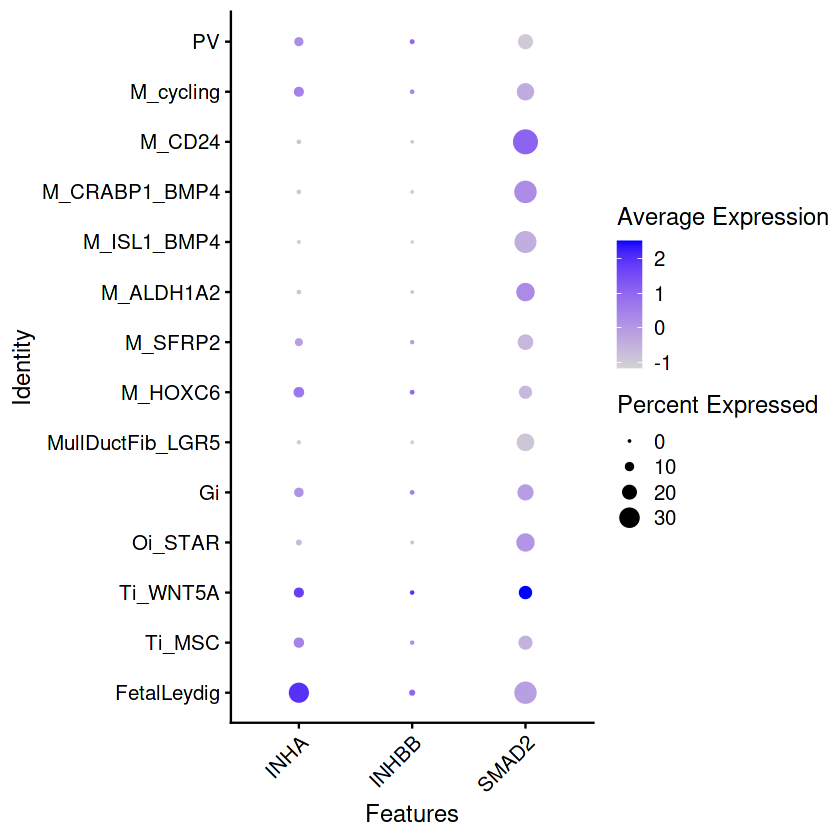

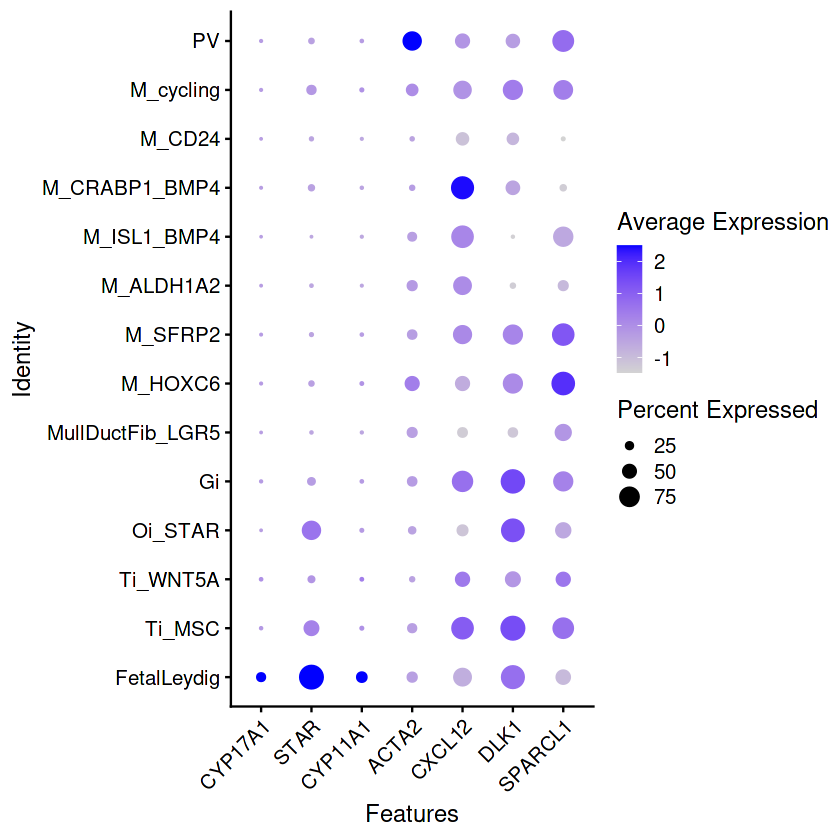

In [39]:
DotPlot(anndataO, features = c('LHX9', 'GATA4', 'ARX', 
                              'GATA2', 'NR2F1', 'ID4')) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0), 
          strip.background = element_rect(fill="#e8eced"))


DotPlot(anndataO, features = c('PTCH1', 'PTCH2', 'IGFBP6')) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0), 
          strip.background = element_rect(fill="#e8eced")) + ggtitle('myoid cells')


DotPlot(anndataO, features = c('HES1', 'NOTCH2') ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0), 
          strip.background = element_rect(fill="#e8eced"))


DotPlot(anndataO, features = c('SFRP1', 'SFRP2') ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0), 
          strip.background = element_rect(fill="#e8eced"))


DotPlot(anndataO, features = c('SLIT1', 'ROBO1') ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0), 
          strip.background = element_rect(fill="#e8eced"))

DotPlot(anndataO, features = c('INHBA', 'SMAD3') ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) # preGC medullar TGFR - activin (INHBA) - proliferation

DotPlot(anndataO, features = c('INHA', 'INHBB', 'SMAD2') ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0), 
          strip.background = element_rect(fill="#e8eced"))



DotPlot(anndataO, features = c('CYP17A1', 'STAR', 'CYP11A1', 'ACTA2', 'CXCL12', 'DLK1', 'SPARCL1') ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0), 
          strip.background = element_rect(fill="#e8eced"))


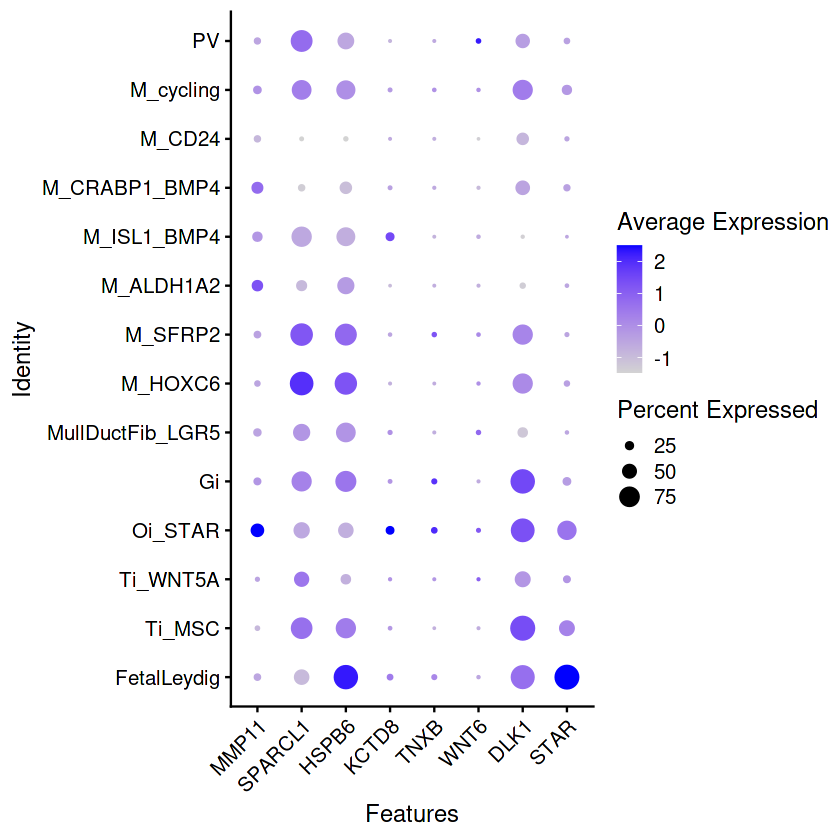

In [40]:
DotPlot(anndataO, features = c( 'MMP11', 'SPARCL1', 'HSPB6', 'KCTD8', 'TNXB', 'WNT6', 'DLK1', 'STAR')) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))

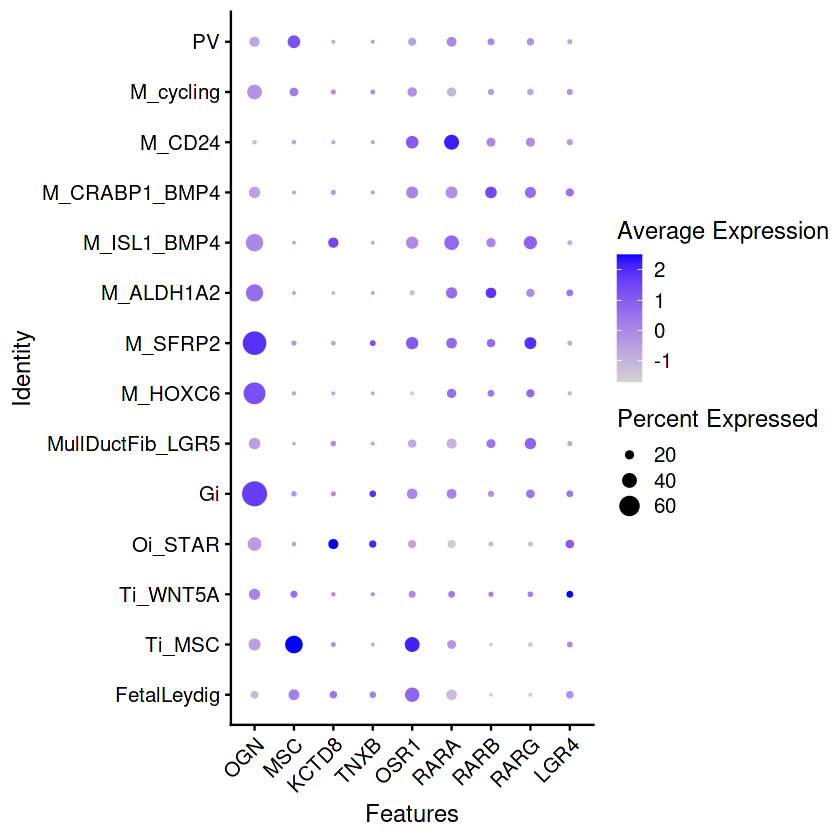

In [41]:
DotPlot(anndataO, features = c( 'OGN', 'MSC', 'KCTD8', 'TNXB', 'OSR1', 'RARA', 'RARB', 'RARG', 'LGR4')) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))

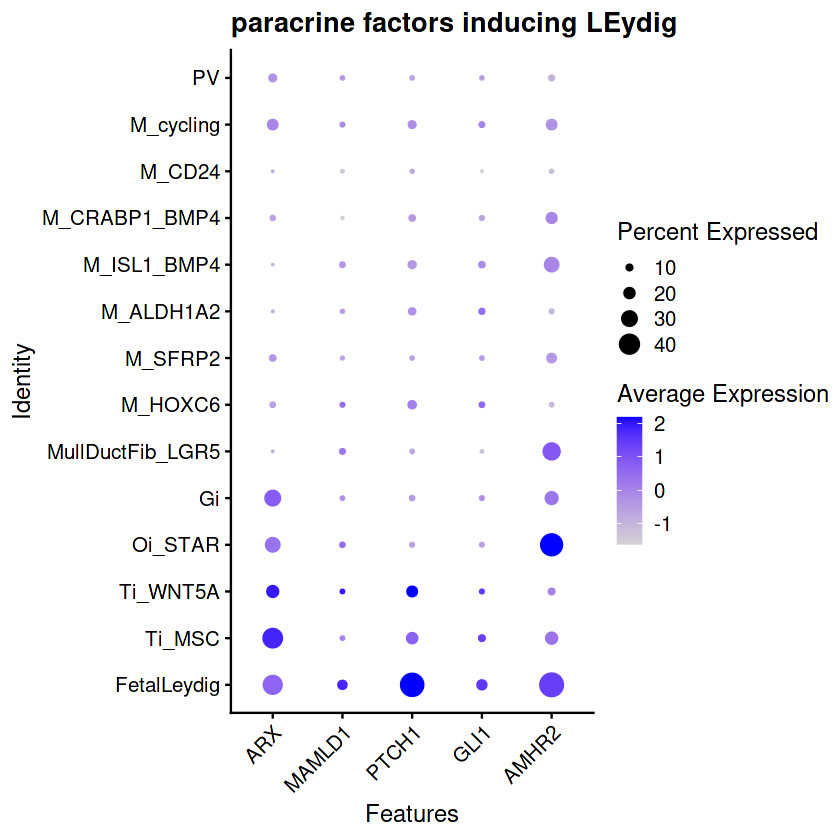

In [42]:
DotPlot(anndataO, features = c( 'ARX', 'MAMLD1', 'PTCH1', 'GLI1', 'AMHR2') ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('paracrine factors inducing LEydig')

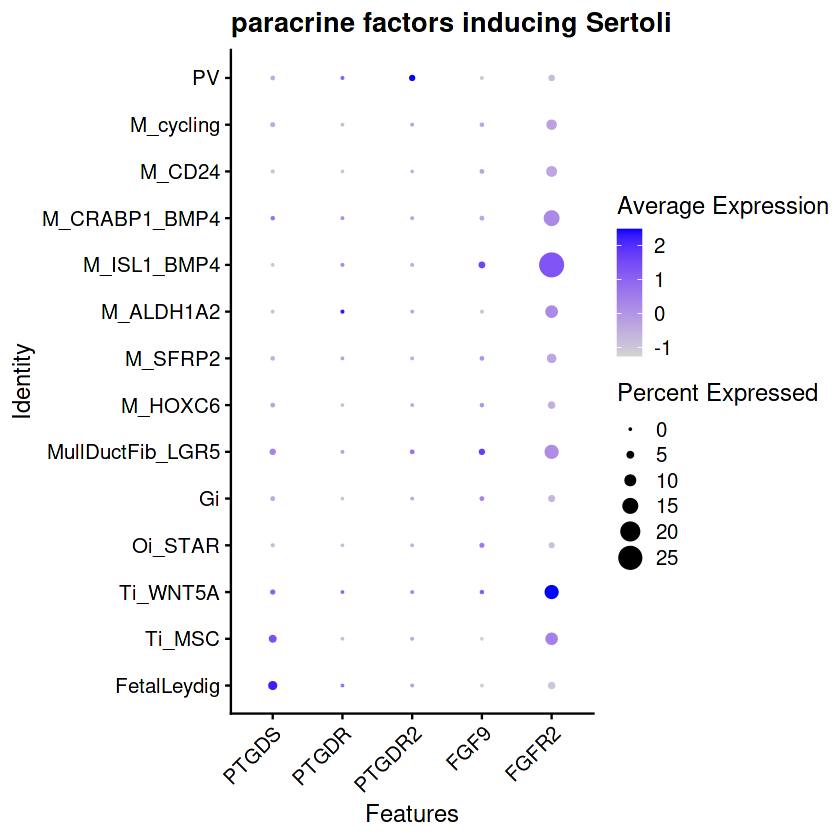

In [43]:
DotPlot(anndataO, features = c('PTGDS', 'PTGDR', 'PTGDR2','FGF9', 'FGFR2') ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('paracrine factors inducing Sertoli')

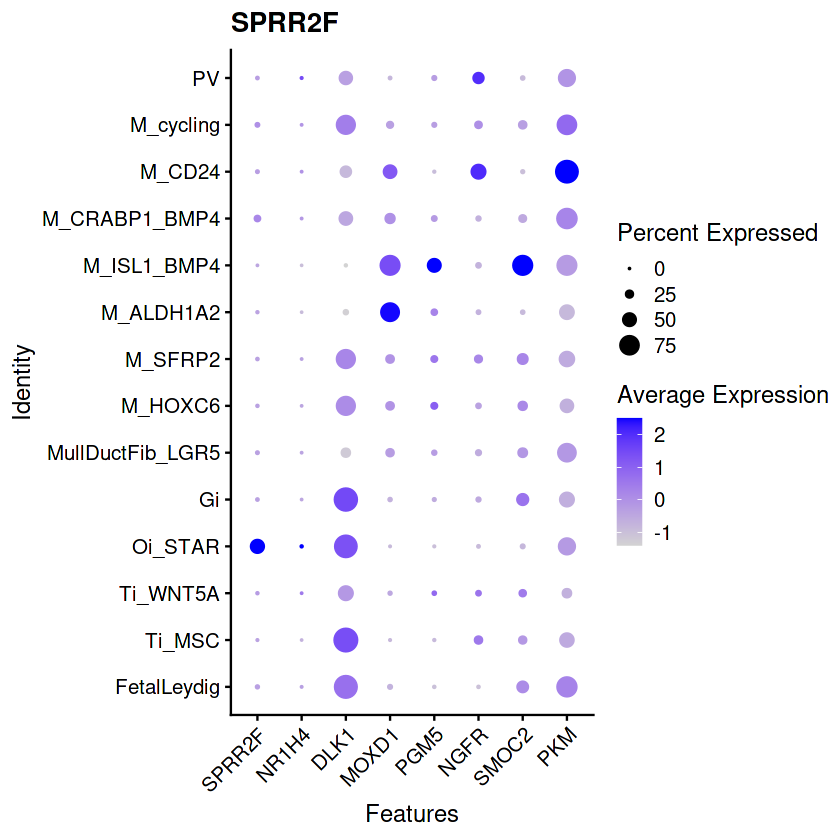

In [44]:
DotPlot(anndataO, features = c('SPRR2F', 'NR1H4', 'DLK1', 'MOXD1', 'PGM5', 'NGFR', 'SMOC2', 'PKM') ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('SPRR2F')

Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found: FRZBENG”


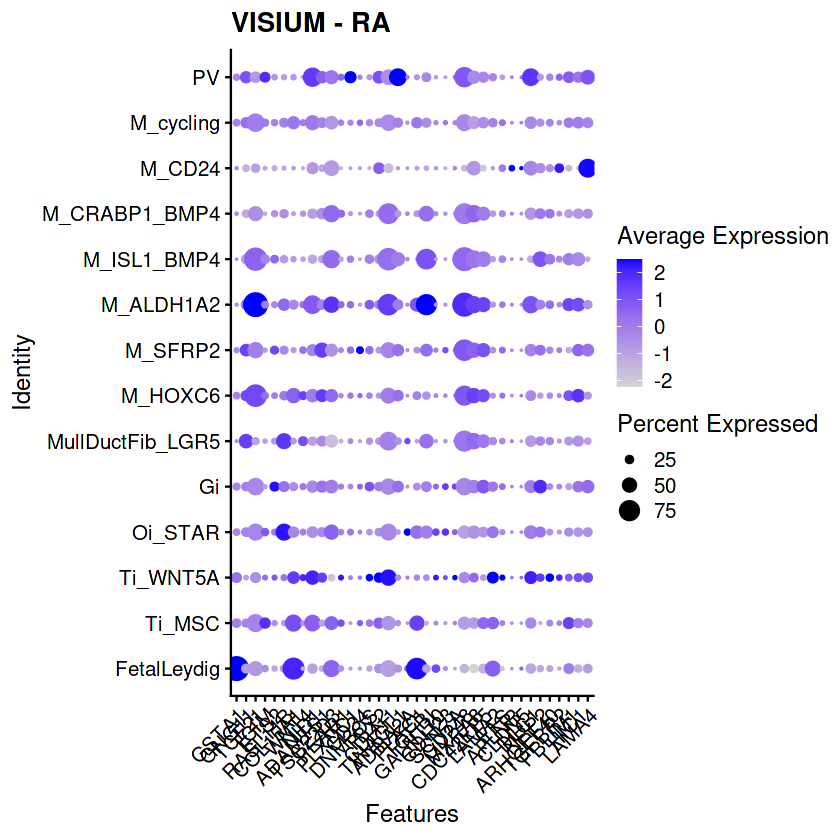

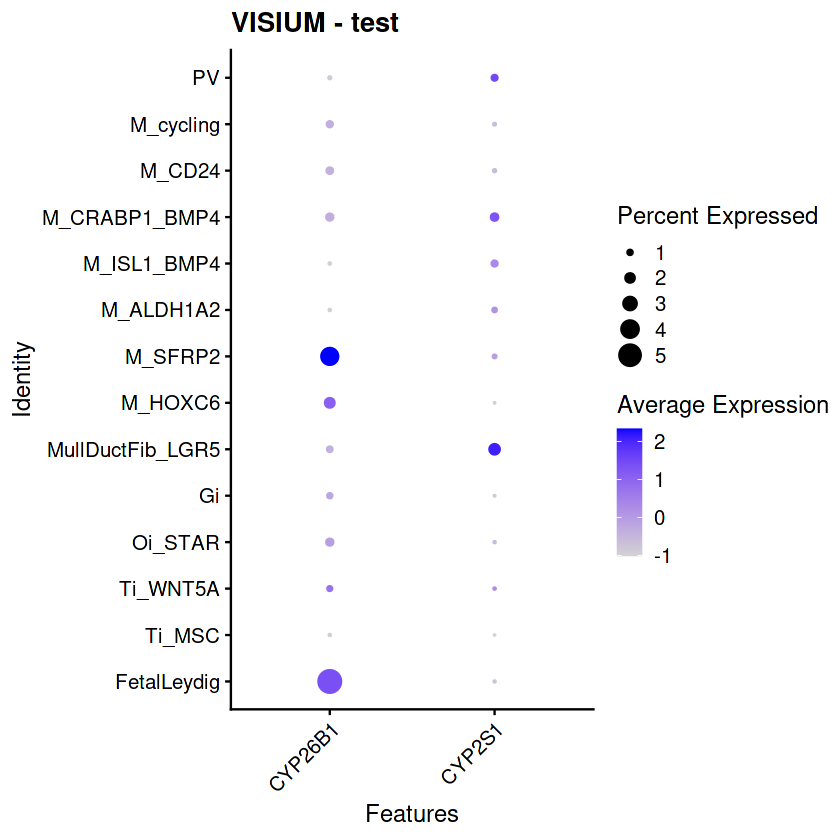

In [45]:
DotPlot(anndataO, features = c('FRZBENG', 'GSTA1', 'GNG11',  'TCF21', 'TCIM',
'ETS2', 'RASL11B', 'COL15A1', 'WNT4', 'NID1', 'ADAMTS1', 'TSC22D3', 'PEAR1',
'PLXDC1', 'CD34', 'DNM3OS', 'TBX2', 'CDH11',
'TINAGL1', 'ADRA2A', 'PLAC1', 'TGFBI', 'GALNT10', 'CDH23',
'SCN7A', 'CD248', 'MXRA8', 'CDC42EP5', 'LAMA2', 'EFS', 'APLNR', 'CLDN5', 'DLC1', 
                            'NRP2', 'ARHGEF40', 'TGFBR2', 'FBLIM1', 'HIC1', 'LAMA4')) + RotatedAxis() +  theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('VISIUM - RA') 



DotPlot(anndataO, features = c('CYP26B1', 'CYP2S1')) + RotatedAxis() +  theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('VISIUM - test') 

## Markers

### High resolution populations

[1] 90102    10

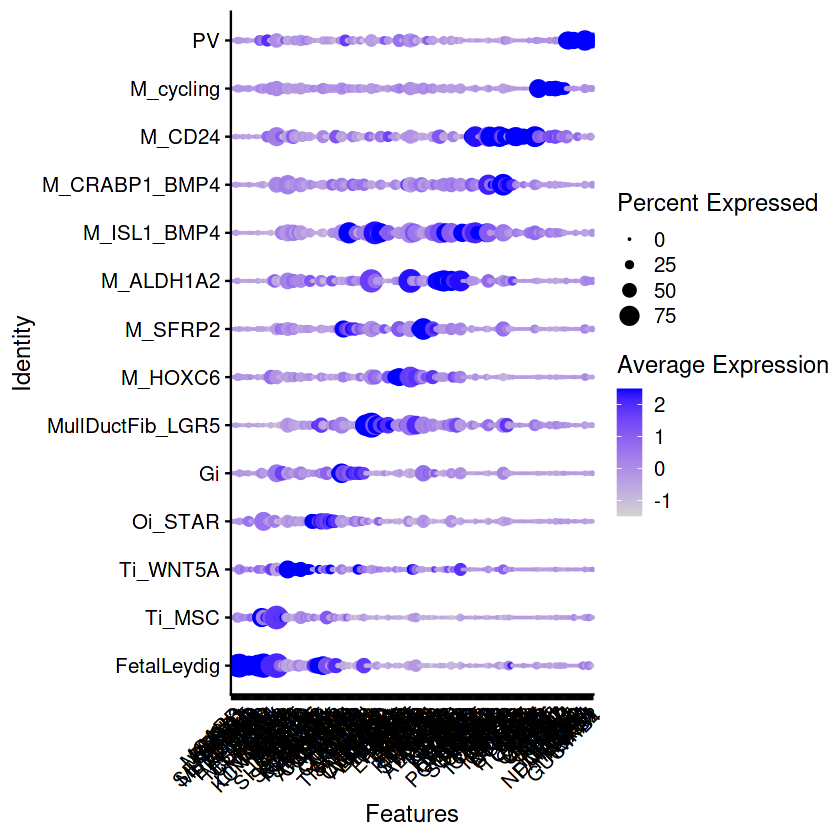

In [46]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = anndataO$annotated_clusters, N = 100000)
dim(df_tfIDF)
write.csv(df_tfIDF, file = 'figures-stromal/0_FS3_table_TFIDF_annotated.csv', quote = F, row.names = F)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(anndataO$annotated_clusters) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'annotated_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-stromal/0_FS3_dotplot_TFIDF_annotated.pdf'), dpi = 75, height = 5, width = 45)

[1] 10967    10

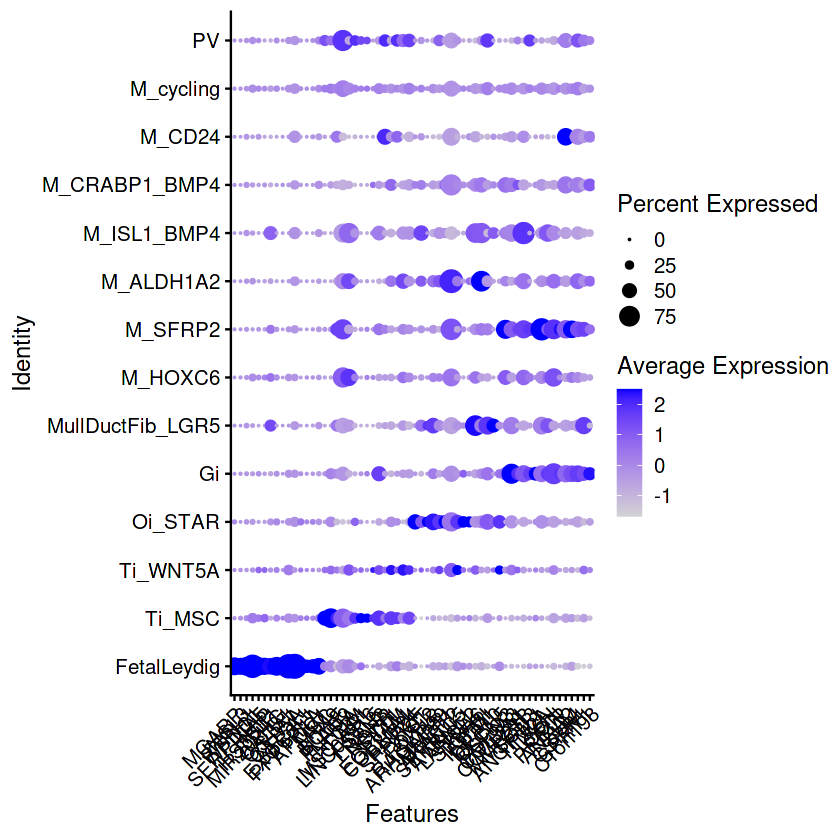

In [47]:
gonadalA = subset(anndataO, cells = colnames(anndataO)[ anndataO$annotated_clusters %in% c('Oi_STAR', 'Ti_MSC', 'FetalLeydig', 'Gi') ] )
gonadDown = downsample_data(gonadalA, N = 1000)

df_tfIDF = quickMarkers(toc = gonadDown@assays$RNA@counts, clusters = gonadDown$annotated_clusters, N = 100000)
dim(df_tfIDF)
write.csv(df_tfIDF, file = 'figures-stromal/0_FS3_table_TFIDF_gonadal.csv', quote = F, row.names = F)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(anndataO$annotated_clusters) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'annotated_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-stromal/0_FS3_dotplot_TFIDF_gonadal.pdf'), dpi = 75, height = 5, width = 45)

In [48]:
# # plot markers of key pathways
# pathway_markers = readRDS(file = '~/farm/gsea/genesets/pathway_markers.rds')
# df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 1000)

# for (pa in names(pathway_markers) ){
#         genes = intersect(pathway_markers[[pa]], df_tfIDF$gene)
#         if(length(genes) <= 1)
#             next()
#         DotPlot(anndataO, features = genes) + RotatedAxis() + ggtitle(pa)
#         ggsave(filename = paste0('figures-stromal/dotplot_annotated_', pa,'.pdf'), dpi = 75, height = 5, width = 10)
# }

# DEGs

To overcome sample-bias, we will downsample each sample using Geometric sketching first and then compute DEGs using Seurat FindAllMarkers()

### All populations

In [49]:
allDown = downsample_data(anndataO, N = 100)

suppressWarnings(dfDEGs <- FindAllMarkers(allDown, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0))
write.csv(dfDEGs, file = 'figures-stromal/0_FS3_table_DEGs.csv', quote = F, row.names = F)

# Plot top DEGs
DEGs = subset(dfDEGs, avg_logFC > 0.5 & p_val_adj < 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs)) + RotatedAxis()
ggsave(filename = paste0('figures-stromal/0_FS3_dotplot_DEGs.pdf'), dpi = 75, height = 7, width = 45)

Calculating cluster FetalLeydig

Calculating cluster Ti_MSC

Calculating cluster Ti_WNT5A

Calculating cluster Oi_STAR

Calculating cluster Gi

Calculating cluster MullDuctFib_LGR5

Calculating cluster M_HOXC6

Calculating cluster M_SFRP2

Calculating cluster M_ALDH1A2

Calculating cluster M_ISL1_BMP4

Calculating cluster M_CRABP1_BMP4

Calculating cluster M_CD24

Calculating cluster M_cycling

Calculating cluster PV



ERROR: Error in eval(e, x, parent.frame()): object 'avg_logFC' not found


### Gonadal populations

In [ ]:
gonadalA = subset(anndataO, cells = colnames(anndataO)[ anndataO$annotated_clusters %in% c('Oi_STAR', 'Ti_MSC', 'FetalLeydig', 'Gi') ] )
gonadDown = downsample_data(gonadalA, N = 1000)

suppressWarnings(dfDEGs <- FindAllMarkers(gonadDown, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0))
write.csv(dfDEGs, file = 'figures-stromal/0_FS3_table_DEGs_LR_gonadal.csv', quote = F, row.names = F)

# Plot top DEGs
DEGs = subset(dfDEGs, avg_logFC > 0.5 & p_val_adj < 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs)) + RotatedAxis()
ggsave(filename = paste0('figures-stromal/0_FS3_dotplot_DEGs_LR_gonadal.pdf'), dpi = 75, height = 7, width = 45)

# Gi between sex

In [ ]:
table(anndataO$annotated_clusters)

In [ ]:
GiA = subset(anndataO, cells = colnames(anndataO)[ anndataO$annotated_clusters %in% c('Gi') ] )
GiDown = downsample_data(GiA, N = 1000, var = 'sex')

Idents(GiDown) = GiDown$sex
suppressWarnings(dfDEGs <- FindAllMarkers(GiDown, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0))
write.csv(dfDEGs, file = 'figures-stromal/0_FS3_table_DEGs_LR_dimorphicGi.csv', quote = F, row.names = F)

# Plot top DEGs
DEGs = subset(dfDEGs, avg_logFC > 0.5 & p_val_adj < 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(GiDown, features = unique(DEGs)) + RotatedAxis()
ggsave(filename = paste0('figures-stromal/0_FS3_dotplot_DEGs_LR_dimorphicGi.pdf'), dpi = 75, height = 7, width = 45)

## TFs activities with Dorothea/VIPER

In [ ]:
source('G_lib_TFacts.r')
# Run Dorothea/viper to get TF activity scores with our custom dorothea_regulon
anndataO_doro <- run_viper(anndataOF, dorothea_regulon,  options = list(method = "scale", minsize = 4, eset.filter = FALSE, cores = 1, verbose = T))
anndataO_doro

# Use FindAllMarkers to estimate differentially activated TFs
DefaultAssay(object = anndataO_doro) <- "dorothea"
anndataO_doro <- ScaleData(anndataO_doro)
suppressWarnings(df_TFact <- FindAllMarkers(anndataO_doro, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0))
df_TFact = df_TFact[ order(df_TFact$avg_logFC, decreasing = T),  ]
write.csv(df_TFact, file = 'figures-stromal/0_FS3_table_TFacts_annotated.csv', quote = F, row.names = F)

In [ ]:
library(dplyr)
library(tibble)
library(pheatmap)
library(tidyr)

# Plot significant TFs
TFs = subset(df_TFact, avg_logFC > 1 & p_val_adj < 0.001) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 20L)$gene) %>%
  unlist(.)

# We transform Viper scores, scaled by seurat, into a data frame to better 
## handling the results
viper_scores_df <- GetAssayData(anndataO_doro, slot = "scale.data", 
                                    assay = "dorothea") %>%
  data.frame(check.names = F) %>%
  t()

viper_scores_df = viper_scores_df[ , unique(TFs)]

## We create a data frame containing the cells and their clusters
CellsClusters <- data.frame(cell = names(Idents(anndataO_doro)), 
                            cell_type = as.character(Idents(anndataO_doro)),
                            check.names = F)

## We create a data frame with the Viper score per cell and its clusters
viper_scores_clusters <- viper_scores_df  %>%
  data.frame() %>% 
  rownames_to_column("cell") %>%
  gather(tf, activity, -cell) %>%
  inner_join(CellsClusters)

## We summarize the Viper scores by cellpopulation
summarized_viper_scores <- viper_scores_clusters %>% 
  group_by(tf, cell_type) %>%
  summarise(avg = mean(activity),
            std = sd(activity))


## We prepare the data for the plot
summarized_viper_scores_df <- summarized_viper_scores %>%
  dplyr::select(-std) %>%   
  spread(tf, avg) %>%
  data.frame(row.names = 1, check.names = FALSE) 

summarized_viper_scores_df = summarized_viper_scores_df[, gsub('-', '.', unique(TFs))]
summarized_viper_scores_df = summarized_viper_scores_df[ levels(Idents(anndataO_doro)), ]

palette_length = 100
my_color = colorRampPalette(c("Darkblue", "white","red"))(palette_length)

my_breaks <- c(seq(min(summarized_viper_scores_df), 0, 
                   length.out=ceiling(palette_length/2) + 1),
               seq(max(summarized_viper_scores_df)/palette_length, 
                   max(summarized_viper_scores_df), 
                   length.out=floor(palette_length/2)))

viper_hmap <- pheatmap(t(summarized_viper_scores_df),fontsize=14, 
                       fontsize_row = 10, 
                       color=my_color, breaks = my_breaks, 
                       main = "TFs", angle_col = 45,
                       treeheight_col = 0,  border_color = NA) 


# Add is TF a DE
dfDEGs$value = ''
dfDEGs$value[ dfDEGs$p_val_adj < 0.05 & dfDEGs$avg_logFC > 0] = '+'
dfDEGs$value[ dfDEGs$p_val_adj < 0.05 & dfDEGs$avg_logFC < 0] = '-'
m = acast(subset(dfDEGs, gene %in% df_TFact$TF), cluster~gene, fill = '')

labels = summarized_viper_scores_df
labels[] = ''
tfs = gsub('.AA$', '', colnames(summarized_viper_scores_df)) %>%  gsub('.[A-E]$', '', .)
for (tf in tfs){
    if (tf %in% colnames(m))
        labels[ rownames(m), tfs == tf ] = m[, tf]
}


viper_hmap <- pheatmap(summarized_viper_scores_df, fontsize=14, display_numbers = labels, cluster_rows = F, 
                       cluster_cols = F,
                       cellwidth = 12, cellheight = 10, 
                       filename = 'figures-stromal/0_FS3_heatmap_TFacts_annotated.pdf',
                       fontsize_row = 10, 
                       color=my_color, breaks = my_breaks, 
                       main = "TFs", angle_col = 90,
                       treeheight_col = 0,  border_color = NA) 

